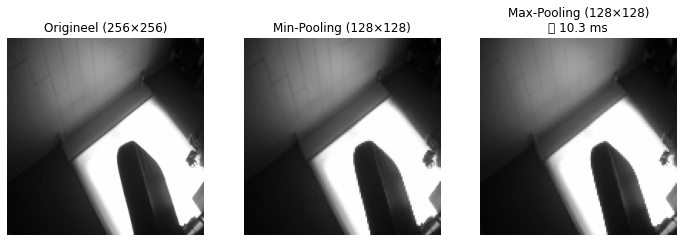

🛑 Live pooling gestopt door gebruiker.


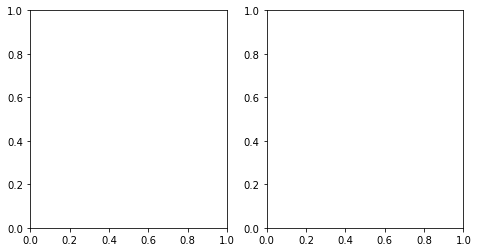

In [1]:
import numpy as np
import cv2
import time
from pynq import Overlay, allocate
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# 1) Laad je bitstream en pooling IP
overlay = Overlay("design_1_wrapper.bit")
pool_ip = overlay.image_pooling_0  # pas aan indien nodig

# 2) Helper om 64-bit bufferadres te splitsen over 2 registers
def write_addr(ip, reg_low, reg_high, addr):
    setattr(ip.register_map, reg_low, addr & 0xFFFFFFFF)
    setattr(ip.register_map, reg_high, (addr >> 32) & 0xFFFFFFFF)

# 3) GStreamer pipeline voor v4l2 webcam JPEG-stream
gst_str = (
    "v4l2src device=/dev/video0 ! "
    "image/jpeg, width=640, height=480, framerate=30/1 ! "
    "jpegdec ! "
    "videoconvert ! "
    "appsink"
)

cap = cv2.VideoCapture(gst_str, cv2.CAP_GSTREAMER)
if not cap.isOpened():
    raise RuntimeError("❌ Kan de webcam niet openen via GStreamer")

print("📹 Live pooling gestart. Stop met Ctrl+C of onderbreek de cel.")

# 4) Parameters voor poolen
IN_H, IN_W = 256, 256
OUT_H, OUT_W = IN_H // 2, IN_W // 2  # 2×2 pooling

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("⚠️ Kon frame niet lezen")
            continue

        # 5) Voorverwerking: grijs + resize
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(gray, (IN_W, IN_H)).astype(np.uint8)

        # 6) Allocate input + twee outputs
        in_buf = allocate(shape=(IN_H, IN_W), dtype=np.uint8)
        out_min = allocate(shape=(OUT_H, OUT_W), dtype=np.uint8)
        out_max = allocate(shape=(OUT_H, OUT_W), dtype=np.uint8)

        np.copyto(in_buf, img)

        # 7) Schrijf adressen naar IP
        write_addr(pool_ip, "src_1",    "src_2",    in_buf.physical_address)
        write_addr(pool_ip, "dst_min_1","dst_min_2",out_min.physical_address)
        write_addr(pool_ip, "dst_max_1","dst_max_2",out_max.physical_address)

        # 8) Start poolen en meet tijd
        t0 = time.time()
        pool_ip.register_map.CTRL.AP_START = 1
        while not pool_ip.register_map.CTRL.AP_DONE:
            pass
        t_elapsed = time.time() - t0

        # 9) Kopieer output buffers
        min_img = out_min.copy()
        max_img = out_max.copy()

        # 10) Visualiseer input, min & max side-by-side
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title(f"Origineel (256×256)")
        axes[1].imshow(min_img, cmap='gray')
        axes[1].set_title(f"Min-Pooling (128×128)")
        axes[2].imshow(max_img, cmap='gray')
        axes[2].set_title(f"Max-Pooling (128×128)\n⏱ {t_elapsed*1000:.1f} ms")
        for ax in axes:
            ax.axis("off")

        clear_output(wait=True)
        display(fig)
        plt.close(fig)

        # 11) Vrijgeven geheugen
        in_buf.freebuffer()
        out_min.freebuffer()
        out_max.freebuffer()

except KeyboardInterrupt:
    print("🛑 Live pooling gestopt door gebruiker.")

finally:
    cap.release()
    cv2.destroyAllWindows()
